This is a walkthrough on how to use [Goombay](https://github.com/lignum-vitae/goombay) and [Biobase](https://github.com/lignum-vitae/biobase) to create a distance matrix and phylogenetic tree to show evolutionary distances between different species with the addition of a substitution matrix.

Install Goombay and Biobase using either `pip` or `uv`. For the purposes of this demonstration, we'll be using `pip`. Outside of Google Colab, the prefix "!" would be omitted while entering the following shell command in the terminal.

In [ ]:
!pip install --upgrade goombay
!pip install --upgrade biobase
!pip install --upgrade numpy
!pip install --upgrade biopython

Goombay has over 20 sequence alignment algorithms including Waterman-Smith-Beyer, Smith-Waterman, Gotoh, and Jaro. For the purposes of this demonstation, we'll be using the Needleman-Wunsch algorithm to globally align the sequences and generate a distance matrix.

The Neighbour Joining algorithm from Goombay will be used to generate the newick tree format needed to generate a visual tree. Newick tree format is a way of representing graph-theoretical trees with edge lengths using parentheses and commas. This allows the tree to be described programmatically before generating the final visual tree.

Phylo and io are used to read the generated newick and display the tree. Although not strictly needed for this example, numpy will be used to make working with 2-D matrices easier.

In [12]:
# Standard library imports
from io import StringIO
import requests

# Third-party imports
from Bio import Phylo
from biobase.matrix import Blosum
from biobase.parser import fasta_parser
from goombay import NeedlemanWunsch, NeighborJoining
import numpy as np

For this example, we'll be working with the `cytochrome b` protein across several species in order to determine evolutionary distance.

- "[BAA06892.1](https://www.ncbi.nlm.nih.gov/protein/BAA06892.1?report=fasta)" - Bubalus bubalis (water buffalo)
- "[YP_001648467.1](https://www.ncbi.nlm.nih.gov/protein/YP_001648467.1?report=fasta)" - Ephydatia muelleri (sea sponge)
- "[AMV74140.1](https://www.ncbi.nlm.nih.gov/protein/AMV74140.1?report=fasta)" - Spongilla lacustris (fresh water sea sponge)
- "[CAA39742.1](https://www.ncbi.nlm.nih.gov/protein/CAA39742.1?report=fasta)" - Sus scrofa (wild boar)
- "[AYV91364.1](https://www.ncbi.nlm.nih.gov/protein/AYV91364.1?report=fasta)" - Halichondria panicea (sea sponge)
- "[AAA19775.1](https://www.ncbi.nlm.nih.gov/protein/AAA19775.1?report=fasta)" - Homo sapiens (human)
- "[P00158.1](https://www.ncbi.nlm.nih.gov/protein/P00158.1?report=fasta)" - Mus musculus (house mouse)
- "[AAL57481.2](https://www.ncbi.nlm.nih.gov/protein/AAL57481.2?report=fasta)" - Bos indicus (zebu/cattle)
- "[BAA85863.1](https://www.ncbi.nlm.nih.gov/protein/BAA85863.1?report=fasta)" - Rattus rattus (black rat)
- "[CAA24007.1](https://www.ncbi.nlm.nih.gov/protein/CAA24007.1?report=fasta)" - Bos taurus (cattle)


In [3]:
accn = ["BAA06892.1", "YP_001648467.1", "AMV74140.1", "CAA39742.1", "AYV91364.1", "AAA19775.1", "P00158.1", "AAL57481.2", "BAA85863.1", "CAA24007.1"]

In [4]:
def get_fasta_data(accessions: list[str]) -> list[str]:
  fasta_seqs = []
  for seq in accessions:
      res = requests.get(f"https://www.ncbi.nlm.nih.gov/sviewer/viewer.fcgi?id={seq}&db=protein&report=fasta")
      fasta_seqs.append(res.text)
  return fasta_seqs

In [5]:
seqs = (get_fasta_data(accn))
print(seqs[0])

>BAA06892.1 cytochrome b (mitochondrion) [Bubalus bubalis]
MTNIRKSHPLMKILNNAFIDLPAPSNISSWWNFGSLLGIWLILQILTGLFLAMHYTSDTTTAFSSVAHIC
RDVNYGWIIRYMHANGASMFFICLYMHVGRGMYYGSYTFLETWNIGVILLFAVMATAFMGYVLPWGQMSF
WGATVITNLLSAIPYIGTSLVEWIWGGFSVDKATLTRFFAFHFILPFIIAALAMVHLLFLHETGSNNPTG
ISSDTDKIPFHPYYTIKDILGALLLILALMLLVLFAPDLLGDPDNYTPANPLNTPPHIKPEWYFLFAYAI
LRSIPNKLGGVLALVLSILILILMPLLHTSKQRSMMFRPFSQCLFWILVANLLTLTWIGGQPVEHPYIII
GQLASITYFLLILVLMPTASMIENNLLKW




After getting the fasta data, it can be parsed with the fasta_parser function from Biobase so that the FASTA header and the sequence itself can easily be accessed separately.

In [6]:
parsed_seqs = []
for seq in seqs:
  parsed = fasta_parser(seq)
  parsed_seqs.extend(parsed)
  print(parsed)

print("\n", parsed_seqs[0].id)
print(parsed_seqs[0].name)
print(parsed_seqs[0].seq)

[FastaRecord(id='BAA06892.1', name='cytochrome b (mitochondrion) [Bubalus bubalis]', seq_len=379)]
[FastaRecord(id='YP_001648467.1', name='cytochrome b (mitochondrion) [Ephydatia muelleri]', seq_len=381)]
[FastaRecord(id='AMV74140.1', name='cytochrome b (mitochondrion) [Spongilla lacustris]', seq_len=381)]
[FastaRecord(id='CAA39742.1', name='cytochrome b (mitochondrion) [Sus scrofa]', seq_len=379)]
[FastaRecord(id='AYV91364.1', name='cytochrome b (mitochondrion) [Halichondria panicea]', seq_len=383)]
[FastaRecord(id='AAA19775.1', name='cytochrome b, partial (mitochondrion) [Homo sapiens]', seq_len=380)]
[FastaRecord(id='sp|P00158.1|CYB_MOUSE', name='RecName: Full=Cytochrome b; AltName: Full=Complex III subunit 3; AltName: Full=Complex III subunit III; AltName: Full=Cytochrome b-c1 complex subunit 3; AltName: Full=Ubiquinol-cytochrome-c reductase complex cytochrome b subunit', seq_len=381)]
[FastaRecord(id='AAL57481.2', name='cytochrome b (mitochondrion) [Bos indicus]', seq_len=379)]
[F

Next, a distance matrix is created by performing a pairwise alignment between each pair of sequences. Since these scores are reflected across the diagonal, duplicate calculations can be skipped and the diagonal can be set directly to zero, which reduces overall computation time.

The BLOSUM62 substitution matrix is being used to more closely represent the likelihood of certain protein swaps happening.

In [13]:
dist_matrix = np.zeros((len(parsed_seqs), len(parsed_seqs)))
needleman_wunsch_62 = NeedlemanWunsch(scoring_matrix=Blosum(62))

for i, subject in enumerate(parsed_seqs):
  for j, query in enumerate(parsed_seqs):
    # Skips duplicate calculations
    if i > j:
      dist_matrix[i, j] = dist_matrix[j, i]
      continue
    # Distance of sequence from itself is 0
    if i == j:
      dist_matrix[i, j] = 0
      continue
    dist = needleman_wunsch_62.normalized_distance(subject.seq, query.seq)
    dist_matrix[i, j] = dist

In [14]:
np.set_printoptions(threshold=np.inf, linewidth=np.inf, precision=8, suppress=True)
print(dist_matrix)

[[0.         0.49081365 0.49028871 0.40457344 0.52149695 0.44596491 0.42099738 0.39912049 0.41877193 0.39912049]
 [0.49081365 0.         0.39317585 0.49028871 0.46614447 0.50166229 0.49011374 0.48906387 0.48836395 0.48906387]
 [0.49028871 0.39317585 0.         0.48696413 0.46144473 0.49868766 0.48573928 0.488014   0.48521435 0.488014  ]
 [0.40457344 0.49028871 0.48696413 0.         0.51714534 0.44438596 0.42222222 0.40439754 0.41947368 0.40439754]
 [0.52149695 0.46614447 0.46144473 0.51714534 0.         0.52480418 0.51749347 0.51714534 0.51505657 0.51679721]
 [0.44596491 0.50166229 0.49868766 0.44438596 0.52480418 0.         0.44461942 0.44421053 0.4454386  0.44385965]
 [0.42099738 0.49011374 0.48573928 0.42222222 0.51749347 0.44461942 0.         0.42344707 0.39755031 0.42344707]
 [0.39912049 0.48906387 0.488014   0.40439754 0.51714534 0.44421053 0.42344707 0.         0.42140351 0.38047493]
 [0.41877193 0.48836395 0.48521435 0.41947368 0.51505657 0.4454386  0.39755031 0.42140351 0.    

Now that a distance matrix has been created, we can perform the last step of creating a phylogenetic tree using the Neighbour Joining method from Goombay.

To generate a tree, first a newick formatted string of the relative distances is created. Next, this string is converted to the file-like string buffer that is the correct type for the input of `Phylo.read()`. After the tree is generated by `Phylo.read()`, it can be displayed to the screen using `Phylo.draw()`.

The number labels at the end of each branch correspond to the index of the original list of accession numbers.

In [15]:
def generate_tree(distance_matrix):
  nj_dist = NeighborJoining(distance_matrix)
  newick = nj_dist.generate_newick()

  handle = StringIO(newick)
  tree = Phylo.read(handle, "newick")
  return tree, newick

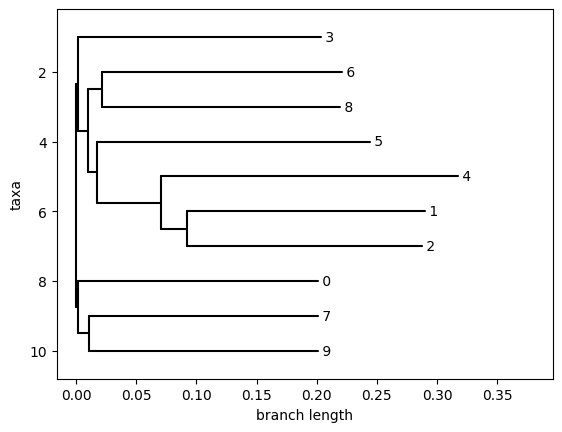

((3:0.20190128684043884,((6:0.19961093366146088,8:0.19793938100337982):0.011291593313217163,(5:0.22698646783828735,(4:0.24609681963920593,(1:0.1979096566910859,2:0.19526619632728676):0.02110985666513443):0.05360579490661621):0.007111191749572754):0.008629314601421356):0.001511983573436737,(0:0.19961155951023102,(7:0.1902899593114853,9:0.19018496572971344):0.00927145779132843):0.001511983573436737);


In [16]:

tree, newick = generate_tree(dist_matrix)
Phylo.draw(tree)
print(newick)

# Key

- [0] Bubalus bubalis (water buffalo)
- [1] Ephydatia muelleri (sea sponge)
- [2] Spongilla lacustris (fresh water sea sponge)
- [3] Sus scrofa (wild boar)
- [4] Halichondria panicea (sea sponge)
- [5] Homo sapiens (human)
- [6] Mus musculus (house mouse)
- [7] Bos indicus (zebu/cattle)
- [8] Rattus rattus (black rat)
- [9] Bos taurus (cattle)